In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data import

In [2]:
df = pd.read_csv("Default.csv", index_col= [0])
df

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879
...,...,...,...,...
9996,No,No,711.555020,52992.378914
9997,No,No,757.962918,19660.721768
9998,No,No,845.411989,58636.156984
9999,No,No,1569.009053,36669.112365


In [3]:
X = df.iloc[:, 1:].values
X

array([['No', 729.526495207286, 44361.6250742669],
       ['Yes', 817.180406555498, 12106.1347003149],
       ['No', 1073.54916401173, 31767.1389473999],
       ...,
       ['No', 845.411989217448, 58636.1569838071],
       ['No', 1569.00905338372, 36669.1123645833],
       ['Yes', 200.922182634797, 16862.9523209407]], dtype=object)

In [4]:
y = df.iloc[:, 0].values
y

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

# Encoding categofical data

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough') #do onehotencode for the column 0 and passthrough for the remainder
X = np.array(ct.fit_transform(X)) #Fit the ColumnTransformer and then make a numpy array

# Encoding the dependent variable

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() #create LabelEncoder
y = le.fit_transform(y) #fit the LabelEncoder and then transform

# Splitting the dataset into the training set and test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

# Feature scaling

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 2:] = sc.fit_transform(X_train[:, 2:]) #train x and fit the model using transform 
X_test[:, 2:] = sc.transform(X_test[:, 2:] ) 

# Training the logit model

In [9]:
from sklearn.linear_model import LogisticRegression
clf0 = LogisticRegression(random_state=0).fit(X_train, y_train)

In [10]:
y_pred = clf0.predict(X_test)

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1924   10]
 [  44   22]]


0.973

In [12]:
clf0.score(X_test, y_test)

0.973

# Training the logit model using regularization and cross-validation

## L1(Lasso) regression penalty 


- the inverse of regularization strength (Cs)
- the number of folds in cross-validation (Cv)
- penalty
- supported penalties (l1) by solver: __liblinear__, saga

In [13]:
from sklearn.linear_model import LogisticRegressionCV
clf1 = LogisticRegressionCV(Cs = [.01], 
                            cv= 5, 
                            penalty = 'l1',
                            solver='liblinear',
                            max_iter=1000,
                            random_state=0).fit(X_train, y_train)

In [14]:
y_pred = clf1.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1932    2]
 [  63    3]]


0.9675

In [16]:
clf1.score(X_test, y_test)

0.9675

## L2(Ridge) regression penalty 

- the inverse of regularization strength (Cs)
- the number of folds in cross-validation (Cv)
- penalty
- supported penalties (l2) by solver: __lbfgs__, liblinear, newton-cg, newton-cholesky, sag, saga

In [17]:
from sklearn.linear_model import LogisticRegressionCV
clf2 = LogisticRegressionCV(Cs = [.001], 
                            cv = 7, 
                            penalty = 'l2', 
                            random_state=0, 
                            solver='lbfgs', 
                            max_iter=1000).fit(X_train, y_train)

In [18]:
y_pred = clf2.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1934    0]
 [  66    0]]


0.967

In [20]:
clf2.score(X_test, y_test)

0.967

- As we play with the regularization tool (type, strength, solver) and the number of folds in K-fold cross-validation, the bigger regression coefficients are penalized. And the model's accuracy becomes smaller (0.973 -> 0.9675 -> 0.967), i.e. regularized. 
- In this case, the inverse of regularization strength (Cs) is critical. 

## The combilation of L1 and L2: Elastic-Net mixing parameter

- The list of Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. A value of 0 is equivalent to using penalty='l2', while 1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.

In [21]:
from sklearn.linear_model import LogisticRegressionCV
clf3 = LogisticRegressionCV(Cs = 1, 
                            cv = 7, 
                            penalty = 'elasticnet', 
                            random_state=0, 
                            solver='saga', 
                            l1_ratios=np.append(np.arange(0.01,1,0.1),[1]),
                            max_iter=1000).fit(X_train, y_train)

In [22]:
y_pred = clf3.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1934    0]
 [  66    0]]


0.967

In [24]:
clf3.score(X_test, y_test)

0.967

- We now can get the accuracy score of 0.967 only with Cs = 1, i.e. with the smaller regularization strength (because it's inverse). 
- With Cs = 10 (default), we gain the exactly same accuracy of the first model, 0.973. 

In [25]:
from sklearn.linear_model import LogisticRegressionCV
clf4 = LogisticRegressionCV(Cs = 10, 
                            cv = 7, 
                            penalty = 'elasticnet', 
                            random_state=0, 
                            solver='saga', 
                            l1_ratios=np.append(np.arange(0.01,1,0.1),[1]),
                            max_iter=1000).fit(X_train, y_train)

In [26]:
y_pred = clf4.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1924   10]
 [  44   22]]


0.973

In [28]:
clf4.score(X_test, y_test)

0.973

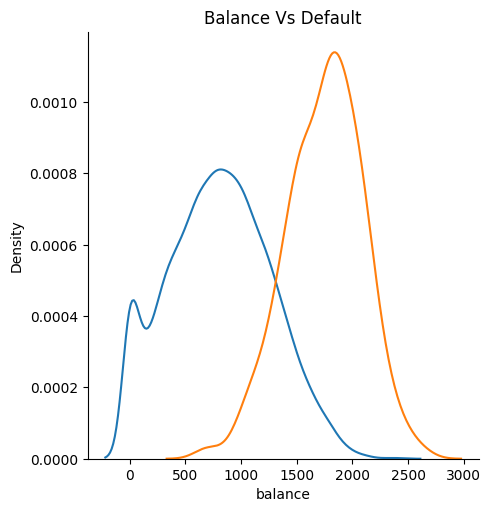

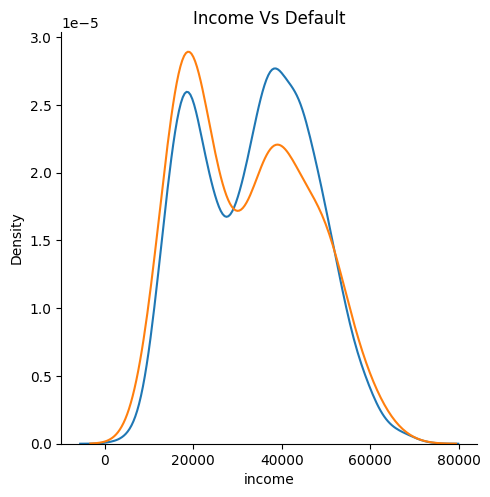

In [29]:
import warnings
warnings.filterwarnings('ignore')
g1 = sns.FacetGrid(df, hue = "default", height= 5)
g1.map(sns.kdeplot, "balance")
plt.title('Balance Vs Default')
g2 = sns.FacetGrid(df, hue = "default", height= 5)
g2.map(sns.kdeplot, "income")
plt.title('Income Vs Default')
plt.show()

In [30]:
import matplotlib.image as mpimg
g1.savefig('g1.png')
plt.close(g1.fig)
g2.savefig('g2.png')
plt.close(g2.fig)

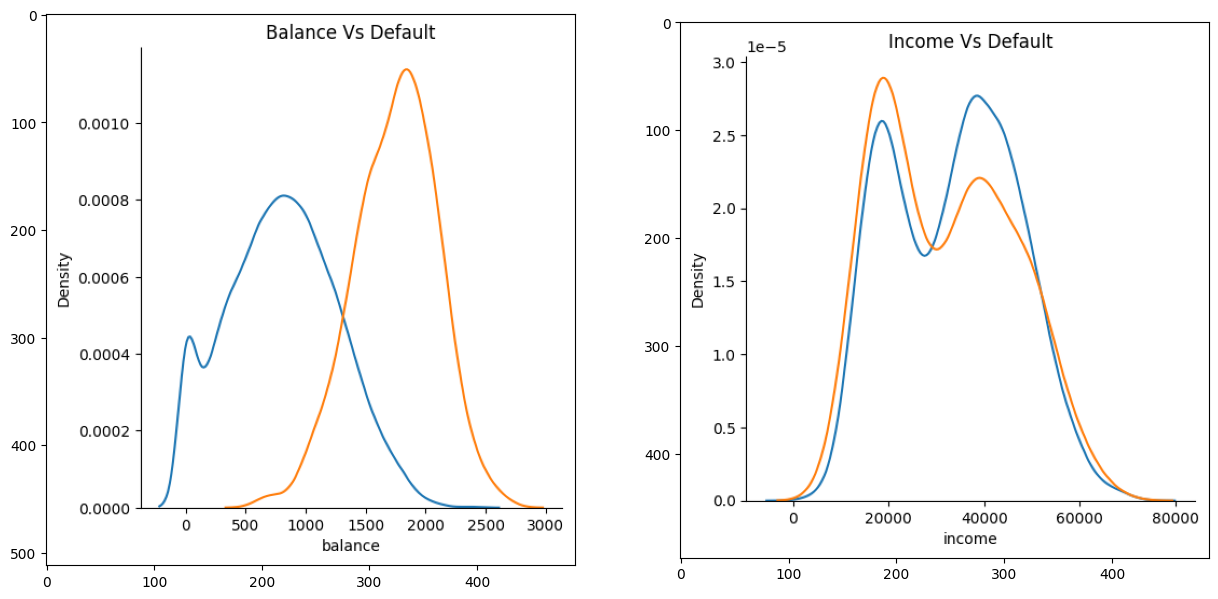

In [31]:
f, axarr = plt.subplots(1, 2, figsize=(15, 20))
axarr[0].imshow(mpimg.imread('g1.png'))
axarr[1].imshow(mpimg.imread('g2.png'))
plt.show()

- As confirmed by the above figure, with this dataset, 'Balance' seems to be a critical feature in deciding the performance of our classifiers. 
- To handle overfitting, either we should gather another dataset to train or use another model to fit.